# 实验二：logistic 回归
姓名：王恩泰    
学号：21114019

In [148]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

# 一、自主实现logistic
## 1.人工构造随机数据集

In [149]:
n_data = torch.ones(100, 2) # 100*2的数据基本形态
x1 = torch.normal(2*n_data,1) # 均值为2，方差为1, 100*2规格的随机数据（Feature）
y1 = torch.zeros(100) # 100个分到0类
x2 = torch.normal(-2*n_data,1) # 均值为-2，方差为1, 100*2规格的随机数据（Feature）
y2 = torch.ones(100) # 100个分到1类

# 合并数据，把所有产生的x,0按行拼接
x_train_data = torch.cat((x1[0:70],x2[0:70]),0).type(torch.FloatTensor)
y_train_data = torch.cat((y1[0:70],y2[0:70]),0).type(torch.FloatTensor)
print(x_train_data.size())
print(y_train_data.size())

x_test_data = torch.cat((x1[70:100],x2[70:100]),0).type(torch.FloatTensor)
y_test_data = torch.cat((y1[70:100],y2[70:100]),0).type(torch.FloatTensor)
print(x_test_data.size())
print(y_test_data.size())

torch.Size([140, 2])
torch.Size([140])
torch.Size([60, 2])
torch.Size([60])


## 2.初始化参数w和b


In [150]:
w = torch.ones((2,1),dtype=torch.float32, requires_grad = True) # 初始w:2*1
# w = torch.tensor(np.random.normal(0,0.01,(2,1)),dtype=torch.float32)
print(w)
b = torch.ones(1,dtype=torch.float32, requires_grad = True) # 初始b:0
print(b)

tensor([[1.],
        [1.]], requires_grad=True)
tensor([1.], requires_grad=True)


## 3.初始化模型

In [151]:
maxiter = 100 # 最大迭代次数
batch_size = 10 # 数据分组量
lr = 0.05 # 学习率
loss = torch.nn.BCELoss()
g_loss_list = []

### 3.1 数据按batch分类

In [152]:
def data_batch(batch_size, x_feature, y_label):
    # 打乱数据按照batch_size分组
    num_x_feature = len(x_feature)
    index = list(range(num_x_feature))
    random.shuffle(index) # 每次大循环打乱一次次序
    for i in range(0,num_x_feature,batch_size):
        index_selct_list = index[i:min(i+batch_size,num_x_feature)] # 这个是int32,要转成int64型才能用index_select
        # print(index_selct_list)
        j = torch.LongTensor(index_selct_list)
        yield x_feature.index_select(0,j), y_label.index_select(0,j) # return仅可返回一个变量，yiled迭代器可以返回一串

### 3.2 logistic模型
$$
p(y=1 \mid \boldsymbol{x}) =\sigma\left(\boldsymbol{w}^{\top} \boldsymbol{x}\right) 
 \triangleq \frac{1}{1+\exp \left(-\boldsymbol{w}^{\top} \boldsymbol{x}\right)}
$$

In [153]:
def logistic(x, w, b):
    y_predict = 1./(1+torch.exp(-1.*(torch.mm(x, w)+b)))
    return y_predict

def grad_descent(arg, lr, batch_size):
    for item in arg:
        item.data = item.data - lr * item.grad / batch_size
    # w = w - lr / batch_size * w.grad
    # b = b - lr / batch_size * b.grad
    # print(w)
    # print(b)
    # return w,b 这样更新不行？？

## 4.训练模型


iter: 49, loss= 0.076741


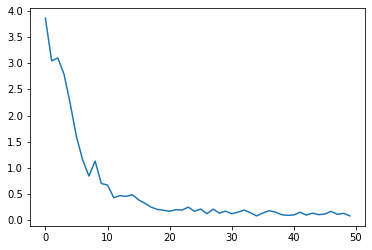

train accuracy value = 1.0
test accuracy value = 0.9833333333333333


In [154]:
for iter in range(maxiter):
    for x_train, y_train in data_batch(batch_size, x_train_data, y_train_data):
        # print(x_train)
        # print(y_train)
        y_predict = logistic(x_train, w, b)
        y_predict = y_predict.squeeze(-1)
        # print(y_predict)        
        loss_val = loss(y_predict, y_train).sum() # 因变量求和
        loss_val.backward() # 自动微分
        grad_descent([w,b],lr,batch_size)
        # print(w)
        # print(b)
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    loss_iter = loss(logistic(x_train, w, b).squeeze(-1), y_train)
    g_loss_list.append(loss_iter.mean().item())

print('iter: %d, loss= %f' % (iter, loss_iter.mean().item())) 
# print(w)
# print(b)
plt.plot(g_loss_list)
plt.show()

# train_accuracy
count = 0 # 计数用于求平均值
acc_sum = 0
for x_test,y_test in data_batch(1, x_train_data, y_train_data): # 逐一batch
    # print(logistic(x_test,w,b).round()) 
    # print(y_test)
    acc_sum += (logistic(x_test,w,b).round() == y_test).item() # 找匹配??
    # print(y_test.shape[0])
    count += 1
train_accuracy_value = acc_sum/count
print('train accuracy value = '+ str(train_accuracy_value))

# test_accuracy
count = 0 # 计数用于求平均值
acc_sum = 0
for x_test,y_test in data_batch(1, x_test_data, y_test_data): # 逐一batch
    # print(logistic(x_test,w,b).round()) 
    # print(y_test)
    acc_sum += (logistic(x_test,w,b).round() == y_test).item() # 找匹配??
    # print(y_test.shape[0])
    count += 1
test_accuracy_value = acc_sum/count
print('test accuracy value = '+ str(test_accuracy_value))

# 二、利用torch.nn 实现 logistic 回归

## 1. 数据存入DataLoader

In [155]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.nn import init
import torch.optim as optim

dataset = Data.TensorDataset(x_train_data, y_train_data)
batch_size = 10
data_loader = Data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 0)

## 2. 构建logistic模型

In [156]:
class LogisticNet(nn.Module):
    def __init__(self, n_feature):
        # 继承nn.Module父类的方法(比如init，线性方法，sigmoid方法)
        super(LogisticNet, self).__init__()
        self.Linear = nn.Linear(n_feature, 1) # nn.Linear两个参数，输入变量维度，输出变量维度, {0,1}相当于一类？
        self.Sigmoid = nn.Sigmoid()

        # 定义前向传播forward函数
    def forward(self,x):
        x = self.Linear(x)
        y = self.Sigmoid(x)
        return y

## 3. 声明优化模型

In [157]:
n_feature = 2
# 实例化一个logisticNet类
logistic_model = LogisticNet(n_feature)
loss = nn.MSELoss()

# 设置学习率
optimizer = optim.SGD(logistic_model.parameters(), lr=0.01)

## 4. 开始学习

iter: 49, loss= 0.007550


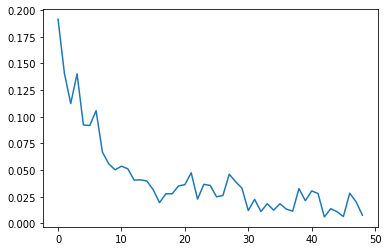

train accuracy value = 1.0
test accuracy value = 1.0


In [158]:
# 初始化梯度
# init.normal_(logistic_model.Linear.weight, mean=0, std=0.01) 
init.constant_(logistic_model.Linear.weight, val=0) # 给系数w设定初始值0
init.constant_(logistic_model.Linear.bias, val=0) # 给系数b设定初始值0

g_loss_list = []
max_iter = 100
for iter in range(1, max_iter):
    for x_train, y_tarin in data_loader:
        # print(x_train)
        # print(y_train)
        y_predict = logistic_model(x_train)
        # print(y_predict)
        loss_val = loss(y_predict.squeeze(-1), y_tarin)        
        optimizer.zero_grad()
        loss_val.backward() # 先backward还是先清零梯度？
        optimizer.step() # 更新所有参数
    g_loss_list.append(loss_val.item())
print('iter: %d, loss= %f' % (iter, loss_val.item()))
plt.plot(g_loss_list)
plt.show()

# train_accuracy
count = 0 # 计数用于求平均值
acc_sum = 0
for x_test,y_test in data_batch(1, x_train_data, y_train_data): # 逐一batch
    acc_sum += (logistic_model(x_test).round() == y_test).item() # 找匹配??
    # print(y_test.shape[0])
    count += 1
train_accuracy_value = acc_sum/count
print('train accuracy value = '+ str(train_accuracy_value))

# test_accuracy
count = 0 # 计数用于求平均值
acc_sum = 0
for x_test,y_test in data_batch(1, x_test_data, y_test_data): # 逐一batch
    acc_sum += (logistic_model(x_test).round() == y_test).item() # 找匹配??
    count += 1
test_accuracy_value = acc_sum/count
print('test accuracy value = '+ str(test_accuracy_value))
